In [1]:
using JLD2, CairoMakie
using Jchemo, JchemoData

In [2]:
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data", "iris.jld2")
@load db dat

1-element Vector{Symbol}:
 :dat

In [3]:
pnames(dat)

(:X,)

In [4]:
summ(dat.X)

(res = 5×7 DataFrame
 Row │ variable      mean    std     min     max        n      nmissing 
     │ Symbol        Union…  Union…  Any     Any        Int64  Int64    
─────┼──────────────────────────────────────────────────────────────────
   1 │ sepal_length  5.843   0.828   4.3     7.9          150         0
   2 │ sepal_width   3.057   0.436   2.0     4.4          150         0
   3 │ petal_length  3.758   1.765   1.0     6.9          150         0
   4 │ petal_width   1.199   0.762   0.1     2.5          150         0
   5 │ species                       setosa  virginica    150         0, ntot = 150)

In [5]:
X = dat.X[:, 1:4]
y = dat.X[:, 5]
n = nro(X)

150

In [6]:
@head(X)

... (150, 4)
 


Row,sepal_length,sepal_width,petal_length,petal_width
,Float64,Float64,Float64,Float64
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2


In [7]:
tab(y)

OrderedCollections.OrderedDict{String, Int64} with 3 entries:
  "setosa"     => 50
  "versicolor" => 50
  "virginica"  => 50

In [8]:
lev = unique(y)

3-element Vector{String}:
 "setosa"
 "versicolor"
 "virginica"

In [9]:
nlev = length(lev)

3

In [10]:
Ydummy = dummy(y).Y
@head Ydummy

... (150, 3)
 


3×3 Matrix{Float64}:
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0

In [11]:
nlv = 2
fm = plskern(X, Ydummy; nlv = nlv) ;

In [12]:
T = fm.T
@head T

... (150, 2)
 


3×2 Matrix{Float64}:
 2.69582  -0.275886
 2.70525   0.243335
 2.87924   0.130817

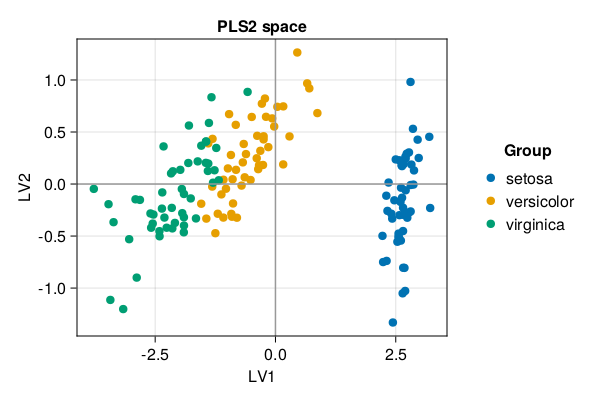

In [13]:
i = 1
plotxy(T[:, i:(i + 1)], y;
    title = "PLS2 space",
    xlabel = string("LV", i), ylabel = string("LV", i + 1),
    zeros = true, ellipse = false).f

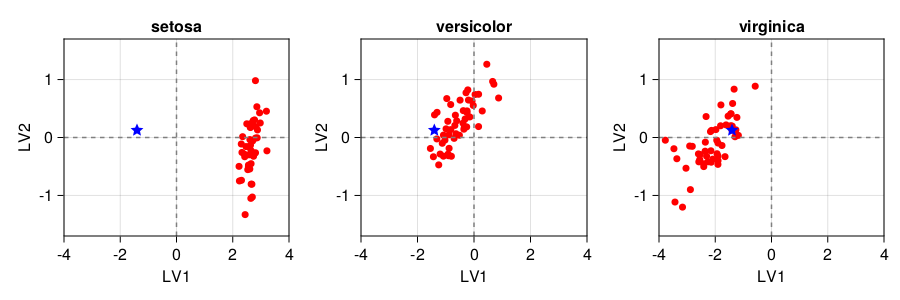

In [14]:
#### Scatters
f = Figure(resolution = (900, 300))
ax = list(nlev)
for i = 1:nlev
    s = y .== lev[i]
    zT = T[s, :]
    ax[i] = Axis(f[1, i]; title = lev[i],
        xlabel = "LV1", ylabel = "LV2")
    scatter!(ax[i], zT[:, 1], zT[:, 2],
        color = :red, markersize = 10)
    # Fictive "new" point to predict
    k = 150
    scatter!(ax[i], T[k, 1], T[k, 2],
        color = :blue, marker = :star5, markersize = 15)
    # End
    hlines!(ax[i], 0; linestyle = "-", color = :grey)
    vlines!(ax[i], 0; linestyle = "-", color = :grey)
    xlims!(ax[i], -4, 4) ; ylims!(ax[i], -1.7, 1.7)
end
f

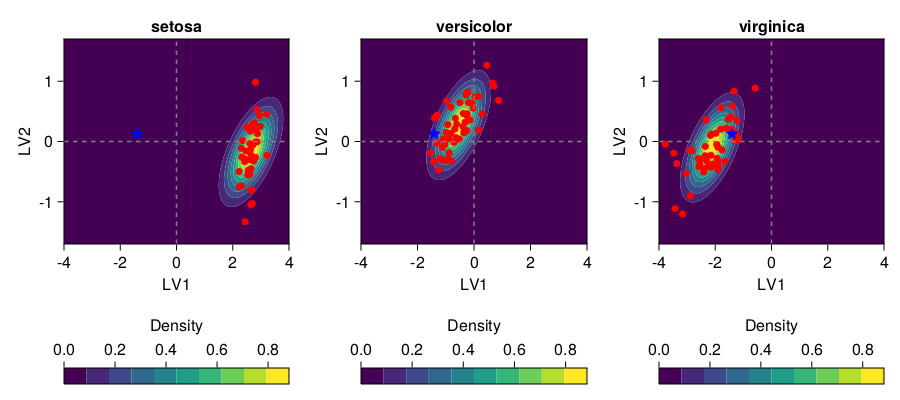

In [15]:
#### LDA
res = matW(T, y)
W = res.W * n / (n - nlev)
npoints = 2^7
x1 = LinRange(-4, 4, npoints)
x2 = LinRange(-2, 2, npoints)
f = Figure(resolution = (900, 400))
ax = list(nlev)
for i = 1:nlev
    s = y .== lev[i]
    zT = T[s, :]
    #lims = [[minimum(zT[:, j]) ; maximum(zT[:, j])] for j = 1:nlv]
    #x1 = LinRange(lims[1][1], lims[1][2], npoints)
    #x2 = LinRange(lims[2][1], lims[2][2], npoints)
    z = mpar(x1 = x1, x2 = x2)
    grid = reduce(hcat, z)
    m = nro(grid)
    zfm = dmnorm(zT; S = W) ;
    zres = Jchemo.predict(zfm, grid) ;
    pred_grid = vec(zres.pred)
    ax[i] = Axis(f[1, i]; title = lev[i],
        xlabel = "LV1", ylabel = "LV2")
    co = contourf!(ax[i], grid[:, 1], grid[:, 2], pred_grid; levels = 10)
    scatter!(ax[i], zT[:, 1], zT[:, 2],
        color = :red, markersize = 10)
    k = 150
    scatter!(ax[i], T[k, 1], T[k, 2],
        color = :blue, marker = :star5, markersize = 15)
    hlines!(ax[i], 0; linestyle = "-", color = :grey)
    vlines!(ax[i], 0; linestyle = "-", color = :grey)
    xlims!(ax[i], -4, 4) ; ylims!(ax[i], -1.7, 1.7)
    Colorbar(f[2, i], co; label = "Density", vertical = false)
end
f

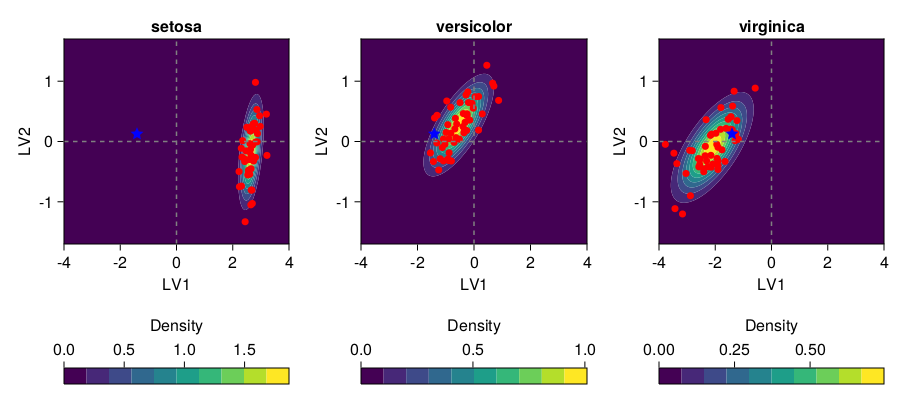

In [16]:
#### QDA
res = matW(T, y)
Wi = res.Wi
ni = res.ni
npoints = 2^7
x1 = LinRange(-4, 4, npoints)
x2 = LinRange(-2, 2, npoints)
f = Figure(resolution = (900, 400))
ax = list(nlev)
for i = 1:nlev
    s = y .== lev[i]
    zT = T[s, :]
    z = mpar(x1 = x1, x2 = x2)
    grid = reduce(hcat, z)
    m = nro(grid)
    S = Wi[i] * ni[i] / (ni[i] - 1)
    zfm = dmnorm(zT; S = S) ;
    zres = Jchemo.predict(zfm, grid) ;
    pred_grid = vec(zres.pred)
    ax[i] = Axis(f[1, i]; title = lev[i],
        xlabel = "LV1", ylabel = "LV2")
    co = contourf!(ax[i], grid[:, 1], grid[:, 2], pred_grid; levels = 10)
    scatter!(ax[i], zT[:, 1], zT[:, 2],
        color = :red, markersize = 10)
    k = 150
    scatter!(ax[i], T[k, 1], T[k, 2],
        color = :blue, marker = :star5, markersize = 15)
    hlines!(ax[i], 0; linestyle = "-", color = :grey)
    vlines!(ax[i], 0; linestyle = "-", color = :grey)
    xlims!(ax[i], -4, 4) ; ylims!(ax[i], -1.7, 1.7)
    Colorbar(f[2, i], co; label = "Density", vertical = false)
end
f

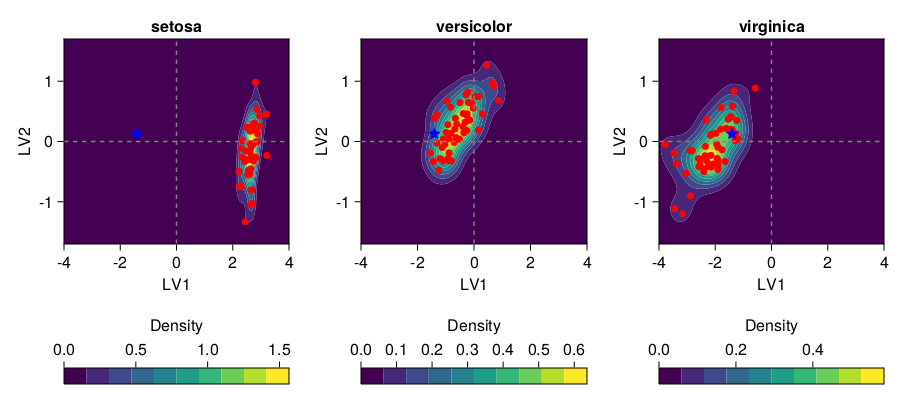

In [17]:
#### Non-parametric
npoints = 2^7
x1 = LinRange(-4, 4, npoints)
x2 = LinRange(-2, 2, npoints)
f = Figure(resolution = (900, 400))
ax = list(nlev)
for i = 1:nlev
    s = y .== lev[i]
    zT = T[s, :]
    z = mpar(x1 = x1, x2 = x2)
    grid = reduce(hcat, z)
    m = nro(grid)
    zfm = dmkern(zT; a = 1) ;
    zres = Jchemo.predict(zfm, grid) ;
    pred_grid = vec(zres.pred)
    ax[i] = Axis(f[1, i]; title = lev[i],
        xlabel = "LV1", ylabel = "LV2")
    co = contourf!(ax[i], grid[:, 1], grid[:, 2], pred_grid; levels = 10)
    scatter!(ax[i], zT[:, 1], zT[:, 2],
        color = :red, markersize = 10)
    k = 150
    scatter!(ax[i], T[k, 1], T[k, 2],
        color = :blue, marker = :star5, markersize = 15)
    hlines!(ax[i], 0; linestyle = "-", color = :grey)
    vlines!(ax[i], 0; linestyle = "-", color = :grey)
    xlims!(ax[i], -4, 4) ; ylims!(ax[i], -1.7, 1.7)
    Colorbar(f[2, i], co; label = "Density", vertical = false)
end
f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*